### Quick Start

The `LANfactory` package is a light-weight convenience package for training `likelihood approximation networks` (LANs) in torch (or keras), 
starting from supplied training data.

[LANs](https://elifesciences.org/articles/65074), although more general in potential scope of applications, were conceived in the context of sequential sampling modeling
to account for cognitive processes giving rise to *choice* and *reaction time* data in *n-alternative forced choice experiments* commonly encountered in the cognitive sciences.

In this quick tutorial we will use the [`ssms`](https://github.com/AlexanderFengler/ssm_simulators) package to generate our training data using such a sequential sampling model (SSM). The use of of the `LANfactory` package is in no way bound to utilize this `ssms` package.

#### Install

To install the `ssms` package type,

`pip install git+https://github.com/AlexanderFengler/ssm_simulators`

To install the `LANfactory` package type,

`pip install git+https://github.com/AlexanderFengler/LANfactory`

Necessary dependency should be installed automatically in the process.

#### Basic Tutorial

In [4]:
# Load necessary packages
import ssms
import lanfactory
import os
import numpy as np
from copy import deepcopy
import torch

passing 1
wandb not available
wandb not available


#### Generate Training Data
First we need to generate some training data. As mentioned above we will do so using the `ssms` python package, however without delving into a detailed explanation
of this package. Please refer to the [basic ssms tutorial] (https://github.com/AlexanderFengler/ssm_simulators) in case you want to learn more.

In [5]:
# MAKE CONFIGS
model = "ddm_deadline"
# Initialize the generator config (for MLP LANs)
generator_config = deepcopy(ssms.config.data_generator_config["lan"])
# Specify generative model (one from the list of included models mentioned above)
generator_config["model"] = model
# Specify number of parameter sets to simulate
generator_config["n_parameter_sets"] = 10000
# Specify how many samples a simulation run should entail
generator_config["n_samples"] = 1000
# Specify folder in which to save generated data
generator_config["output_folder"] = "data/lan_mlp/" + model + "/"

# Make model config dict
model_config = ssms.config.model_config[model.split("_deadline")[0]]

In [9]:
# MAKE DATA

my_dataset_generator = ssms.dataset_generators.lan_mlp.data_generator(
    generator_config=generator_config, model_config=model_config
)

for i in range(25):
    print(i)
    training_data = my_dataset_generator.generate_data_training_uniform(save=True)

{'name': 'ddm_deadline', 'params': ['v', 'a', 'z', 't', 'deadline'], 'param_bounds': [[-3.0, 0.3, 0.1, 0.0, 0.001], [3.0, 2.5, 0.9, 2.0, 10]], 'boundary_name': 'constant', 'boundary': <function constant at 0x111b4ec20>, 'boundary_params': [], 'n_params': 5, 'default_params': [0.0, 1.0, 0.5, 0.001, 10], 'nchoices': 2, 'simulator': <cyfunction ddm_flexbound at 0x177b3e4d0>}
n_cpus used:  12
checking:  data/lan_mlp/ddm_deadline/
0
simulation round: 1  of 10


simulation round: 2  of 10
simulation round: 3  of 10
simulation round: 4  of 10
simulation round: 5  of 10
simulation round: 6  of 10
simulation round: 7  of 10
simulation round: 8  of 10
simulation round: 9  of 10
simulation round: 10  of 10
Writing to file:  data/lan_mlp/ddm_deadline//training_data_2740c416c0b711eeaa2f6ae25f443f62.pickle
1
simulation round: 1  of 10
simulation round: 2  of 10
simulation round: 3  of 10
simulation round: 4  of 10
simulation round: 5  of 10
simulation round: 6  of 10
simulation round: 7  of 10
simulation round: 8  of 10
simulation round: 9  of 10
simulation round: 10  of 10
Writing to file:  data/lan_mlp/ddm_deadline//training_data_4efa2682c0b711eeaa2f6ae25f443f62.pickle
2
simulation round: 1  of 10
simulation round: 2  of 10
simulation round: 3  of 10
simulation round: 4  of 10
simulation round: 5  of 10
simulation round: 6  of 10
simulation round: 7  of 10
simulation round: 8  of 10
simulation round: 9  of 10
simulation round: 10  of 10
Writing to f

In [ ]:
# training_data

'Dataset completed'

#### Prepare for Training

Next we set up dataloaders for training with pytorch. The `LANfactory` uses custom dataloaders, taking into account particularities of the expected training data.
Specifically, we expect to receive a bunch of training data files (the present example generates only one), where each file hosts a large number of training examples. 
So we want to define a dataloader which spits out batches from data with a specific training data file, and keeps checking when to load in a new file. 
The way this is implemented here, is via the `DatasetTorch` class in `lanfactory.trainers`, which inherits from `torch.utils.data.Dataset` and prespecifies a `batch_size`. Finally this is supplied to a [`DataLoader`](https://pytorch.org/docs/stable/data.html), for which we keep the `batch_size` argument at 0.

The `DatasetTorch` class is then called as an iterator via the DataLoader and takes care of batching as well as file loading internally. 

You may choose your own way of defining the `DataLoader` classes, downstream you are simply expected to supply one.

In [9]:
# MAKE DATALOADERS

# List of datafiles (here only one)
folder_ = "data/lan_mlp/" + model + "/"  # + "/training_data_0_nbins_0_n_1000/"
file_list_ = [folder_ + file_ for file_ in os.listdir(folder_)]
feature_key = "cpn_data"
label_key = "cpn_labels"

# Training dataset
torch_training_dataset = lanfactory.trainers.DatasetTorch(
    file_ids=file_list_,
    batch_size=1024,
    features_key=feature_key,
    label_key=label_key,
)

torch_training_dataloader = torch.utils.data.DataLoader(
    torch_training_dataset,
    shuffle=True,
    batch_size=None,
    num_workers=1,
    pin_memory=True,
)

# Validation dataset
torch_validation_dataset = lanfactory.trainers.DatasetTorch(
    file_ids=file_list_,
    batch_size=1024,
    features_key=feature_key,
    label_key=label_key,
)

torch_validation_dataloader = torch.utils.data.DataLoader(
    torch_validation_dataset,
    shuffle=True,
    batch_size=None,
    num_workers=1,
    pin_memory=True,
)

Now we define two configuration dictionariers,

1. The `network_config` dictionary defines the architecture and properties of the network
2. The `train_config` dictionary defines properties concerning training hyperparameters

Two examples (which we take as provided by the package, but which you can adjust according to your needs) are provided below.

In [6]:
# SPECIFY NETWORK CONFIGS AND TRAINING CONFIGS
network_type = "cpn"
if network_type == "cpn":
    network_config = lanfactory.config.network_configs.network_config_cpn
    train_config = lanfactory.config.network_configs.train_config_cpn
elif network_type == "lan":
    network_config = lanfactory.config.network_configs.network_config_mlp
    train_config = lanfactory.config.network_configs.train_config_mlp
elif network_type == "opn":
    network_config = lanfactory.config.network_configs.network_config_cpn
    train_config = lanfactory.config.network_configs.train_config_cpn

print("Network config: ")
print(network_config)

print("Train config: ")
print(train_config)

Network config: 
{'layer_sizes': [100, 100, 1], 'activations': ['tanh', 'tanh', 'linear'], 'train_output_type': 'logits'}
Train config: 
{'cpu_batch_size': 128, 'gpu_batch_size': 256, 'n_epochs': 5, 'optimizer': 'adam', 'learning_rate': 0.002, 'lr_scheduler': 'reduce_on_plateau', 'lr_scheduler_params': {}, 'weight_decay': 0.0, 'loss': 'bcelogit', 'save_history': True}


We can now load a network, and save the configuration files for convenience.

In [5]:
# LOAD NETWORK
net = lanfactory.trainers.TorchMLP(
    network_config=deepcopy(network_config),
    input_shape=torch_training_dataset.input_dim,
    save_folder="data/torch_models/" + model + "/",
    generative_model_id="angle",
)

# SAVE CONFIGS
lanfactory.utils.save_configs(
    model_id="angle" + "_torch_",
    save_folder="data/torch_models/" + model + "/",
    network_config=network_config,
    train_config=train_config,
    allow_abs_path_folder_generation=True,
)

tanh
tanh
linear
Found folder:  data
Moving on...
Found folder:  data/torch_models
Moving on...
Found folder:  data/torch_models/ddm_deadline
Moving on...
Saved network config
Saved train config


In [52]:
help(lanfactory.trainers.ModelTrainerTorchMLP.train_and_evaluate)

Help on function train_and_evaluate in module lanfactory.trainers.torch_mlp:

train_and_evaluate(self, output_folder='data/', output_file_id='fileid', run_id='runid', wandb_on=True, wandb_project_id='projectid', save_history=True, save_model=True, save_config=True, save_all=True, save_data_details=True, verbose=1)
    Train and evaluate the model.
    
    Arguments
    ---------
        output_folder (str):
            Output folder.
        output_file_id (str):
            Output file ID.
        run_id (str):
            Run ID.
        wandb_on (bool):
            Whether to use wandb.
        wandb_project_id (str):
            Wandb project ID.
        save_history (bool):
            Whether to save the training history.
        save_model (bool):
            Whether to save the model.
        save_config (bool):
            Whether to save the training configuration.
        save_all (bool):
            Whether to save all.
        save_data_details (bool):
            Whether

In [70]:
# train_config

# train_config["n_epochs"] = 25

To finally train the network we supply our network, the dataloaders and training config to the `ModelTrainerTorchMLP` class, from `lanfactory.trainers`.

In [7]:
# TRAIN MODEL
n_epochs = 20
train_config["n_epochs"] = n_epochs

model_trainer = lanfactory.trainers.ModelTrainerTorchMLP(
    model=net,
    train_config=train_config,
    train_dl=torch_training_dataloader,
    valid_dl=torch_validation_dataloader,
    allow_abs_path_folder_generation=False,
    pin_memory=True,
    seed=None,
)

# model_trainer.train_model(save_history=True, save_model=True, verbose=0)
model_trainer.train_and_evaluate(
    wandb_on=False,
    output_folder="data/torch_models/" + model + "_cpn" + "/",
    output_file_id=model,
)
# LOAD MODEL

NameError: name 'net' is not defined

#### Load Model for Inference and Call

The `LANfactory` provides some convenience functions to use networks for inference after training. 
We can load a model using the `LoadTorchMLPInfer` class, which then allows us to run fast inference via either
a direct call, which expects a `torch.tensor` as input, or the `predict_on_batch` method, which expects a `numpy.array` 
of `dtype`, `np.float32`. 

In [10]:
network_path_list = os.listdir("data/torch_models/" + model + "_cpn")
network_file_path = [
    "data/torch_models/" + model + "_cpn" + "/" + file_
    for file_ in network_path_list
    if "state_dict" in file_
][0]

network = lanfactory.trainers.LoadTorchMLPInfer(
    model_file_path=network_file_path,
    network_config=network_config,
    input_dim=torch_training_dataset.input_dim,
)

tanh
tanh
linear


In [11]:
network_file_path

'data/torch_models/ddm_deadline_cpn/ddm_deadline_cpn_runid_train_state_dict_torch.pt'

In [12]:
# Two ways to call the network

# Direct call --> need tensor input
direct_out = network(
    torch.from_numpy(np.array([1, 1.5, 0.5, 1.0, 1], dtype=np.float32))
)
print("direct call out: ", direct_out)

# predict_on_batch method
predict_on_batch_out = network.predict_on_batch(
    np.array([1, 1.5, 0.5, 1.0, 1], dtype=np.float32)
)
print("predict_on_batch out: ", predict_on_batch_out)

direct call out:  tensor([-0.8193])
predict_on_batch out:  [-0.8192596]


#### A peek into the first passage distribution computed by the network

We can compare the learned likelihood function in our `network` with simulation data from the underlying generative model.
For this purpose we recruit the [`ssms`](https://github.com/AlexanderFengler/ssm_simulators) package again.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from ssms.basic_simulators.simulator import simulator

data = pd.DataFrame(
    np.zeros((2000, 5), dtype=np.float32),
    columns=["v", "a", "z", "t", "deadline"],
)
data["v"] = np.linspace(-2.0, 2.0, 2000)
data["a"] = 1.5
data["z"] = 0.5
data["t"] = 0.2
# data["theta"] = 0.1
data["deadline"] = 2.0

# Network predictions
network_predictions = []

# Simulations
choice_p_vec = np.zeros((10, 20))  # np.zeros(20, 20)
for i, deadline in enumerate(np.linspace(0.5, 2.5, 10)):
    data["v"] = np.linspace(-2.0, 2.0, 2000)
    data["deadline"] = deadline
    network_predictions.append(network.predict_on_batch(data.values.astype(np.float32)))
    for j, v in enumerate(np.linspace(-2.0, 2.0, 20)):
        data["v"] = v
        sim_out = simulator(model=model, theta=data.values[0, :], n_samples=10000)
        choice_p_vec[i, j] = sim_out["choice_p"][0, 0]

/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_ssm_simulators/ssm-simulators/ssms/basic_simulators/simulator.py:399: UserWarning: Deadline model request, and theta not supplied as dict.Make sure to supply the deadline parameters in last position!
  warnings.warn(


Text(0, 0.5, 'likelihod')

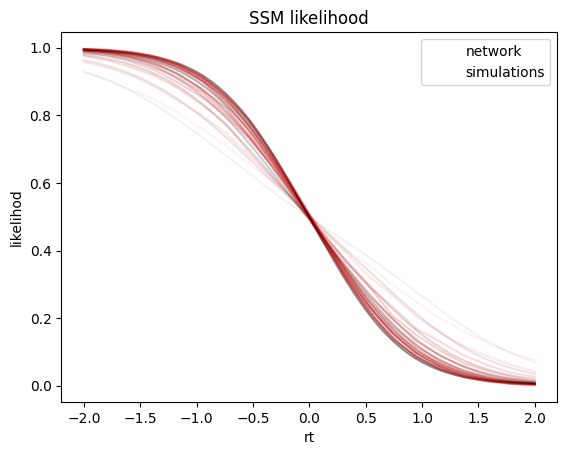

In [14]:
# Plot network predictions
# Plot simulations
for i in range(10):
    plt.plot(
        np.linspace(-2, 2, 2000),
        np.exp(network_predictions[i][:, 0]),
        color="black",
        label=None if i > 0 else "network",
        alpha=i / 20,
    )

    plt.plot(
        np.linspace(-2, 2, 20),
        np.array(choice_p_vec[i, :]),
        color="red",
        label=None if i > 0 else "simulations",
        alpha=i / 20,
    )

plt.legend()
plt.title("SSM likelihood")
plt.xlabel("rt")
plt.ylabel("likelihod")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.DataFrame(
    np.zeros((2000, 7), dtype=np.float32),
    columns=["v", "a", "z", "t", "theta", "rt", "choice"],
)
data["v"] = 0.5
data["a"] = 0.75
data["z"] = 0.5
data["t"] = 0.2
data["theta"] = 0.1
data["rt"].iloc[:1000] = np.linspace(20, 0, 1000)
data["rt"].iloc[1000:] = np.linspace(0, 20, 1000)
data["choice"].iloc[:1000] = -1
data["choice"].iloc[1000:] = 1

# Network predictions
predict_on_batch_out = network.predict_on_batch(data.values.astype(np.float32))

# Simulations
from ssms.basic_simulators.simulator import simulator

sim_out = simulator(model="angle", theta=data.values[0, :-2], n_samples=2000)

/var/folders/gx/s43vynx550qbypcxm83fv56dzq4hgg/T/ipykernel_25238/1241343318.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["rt"].iloc[:1000] = np.linspace(20, 0, 1000)
/var/folders/gx/s43vynx550qbypcxm83fv56dzq4hgg/T/ipykernel_25238/1241343318.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[20.         19.97997998 19.95995996 19.93993994 19.91991992 19.8998999
 19.87987988 19.85985986 19.83983984 19.81981982 19.7997998  19.77977978
 19.75975976 19.73973974 19.71971972 19.6996997  19.67967968 19.65965966
 19.63963964 19.61961962 19.5995996  19.57957958 19.55955956 19.53953954
 19.51951952 19.4994995  19.47947948 19.45945946 19.43943944 19.41941942
 19.3993994  19.37937938 19.35935936 19.33933934 19.31931932 19.29929

Text(0, 0.5, 'likelihod')

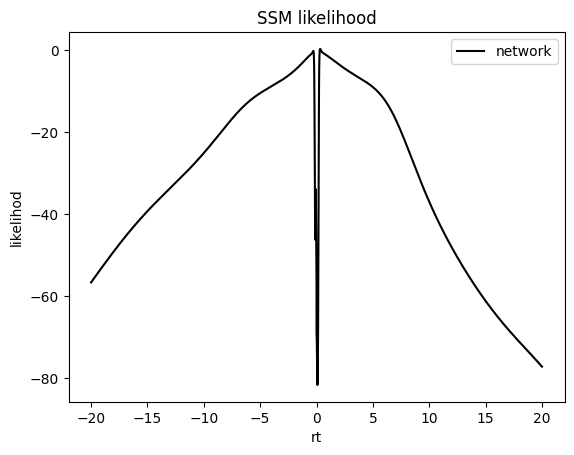

In [ ]:
# Plot network predictions
plt.plot(
    data["rt"] * data["choice"],
    predict_on_batch_out,
    color="black",
    label="network",
)

# Plot simulations
# plt.hist(
#     sim_out["rts"] * sim_out["choices"],
#     bins=100,
#     histtype="step",
#     label="simulations",
#     color="blue",
#     density=True,
# )
plt.legend()
plt.title("SSM likelihood")
plt.xlabel("rt")
plt.ylabel("likelihod")

We hope this package may be helpful in case you attempt to train [LANs](https://elifesciences.org/articles/65074) for your own research.

#### END